/Users/porkr/projects/ea_scraper/fc2026/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/porkr/projects/ea_scraper/fc2026/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using: CPU
Loaded 1551 posts
Loading models (this may take a minute)...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Device set to use cpu
Device set to use cpu


✅ All models loaded!
Analyzing with RoBERTa (Twitter-trained)...


RoBERTa: 100%|████████████████████████████████| 1551/1551 [00:51<00:00, 29.99it/s]


Analyzing with DistilBERT...


DistilBERT: 100%|█████████████████████████████| 1551/1551 [00:26<00:00, 59.29it/s]


Analyzing with 5-star BERT model...


5-Star BERT: 100%|████████████████████████████| 1551/1551 [00:53<00:00, 29.14it/s]


TRANSFORMER-BASED SENTIMENT ANALYSIS RESULTS

📊 Total Posts Analyzed: 1551

----------------------------------------
RoBERTa (Twitter-trained) Results:
----------------------------------------
roberta_sentiment
Negative    1221
Neutral      280
Positive      50
Name: count, dtype: int64

----------------------------------------
DistilBERT Results:
----------------------------------------
distilbert_sentiment
Negative    1458
Positive      93
Name: count, dtype: int64

----------------------------------------
5-Star Rating Distribution:
----------------------------------------
star_rating
1    1109
2     255
3      95
4      46
5      46
Name: count, dtype: int64

----------------------------------------
🎯 CONSENSUS (All Models Combined):
----------------------------------------
consensus_sentiment
Negative    1419
Neutral       74
Positive      58
Name: count, dtype: int64

Percentages:
consensus_sentiment
Negative    91.5
Neutral      4.8
Positive     3.7
Name: proportion, dtype: floa

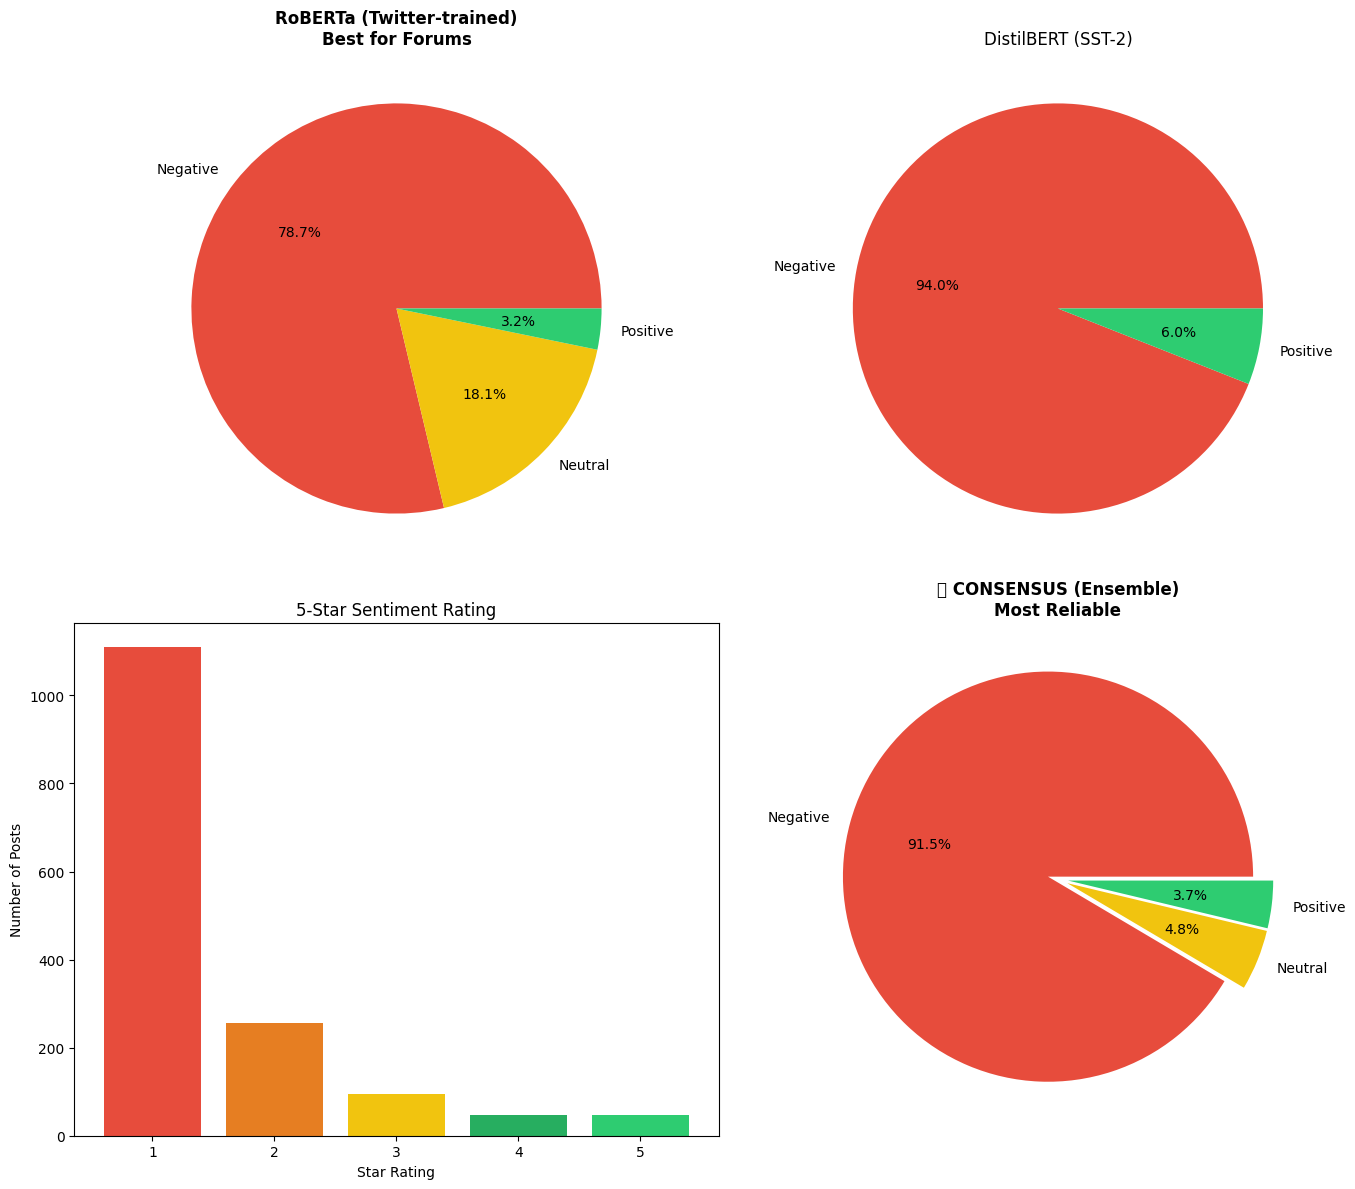

<Figure size 1400x800 with 0 Axes>

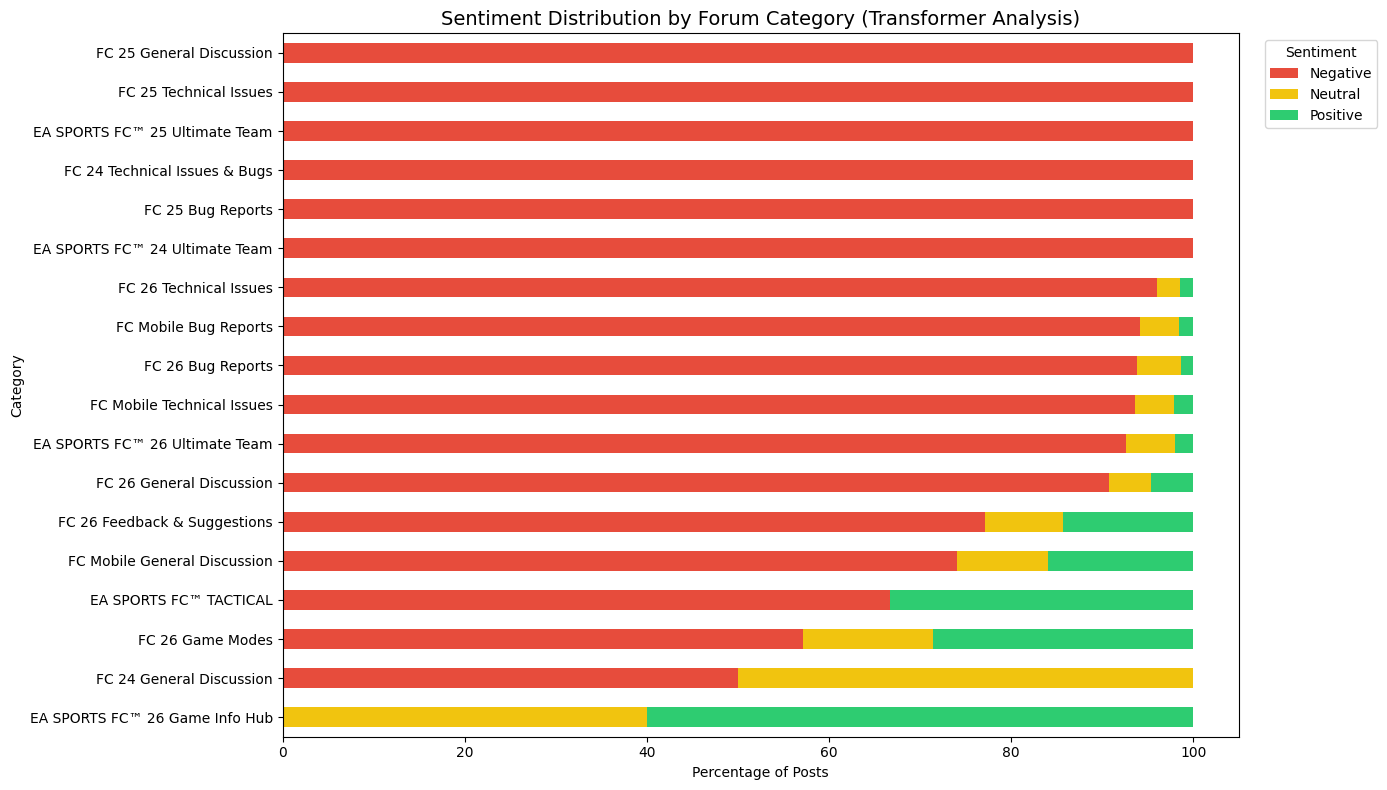

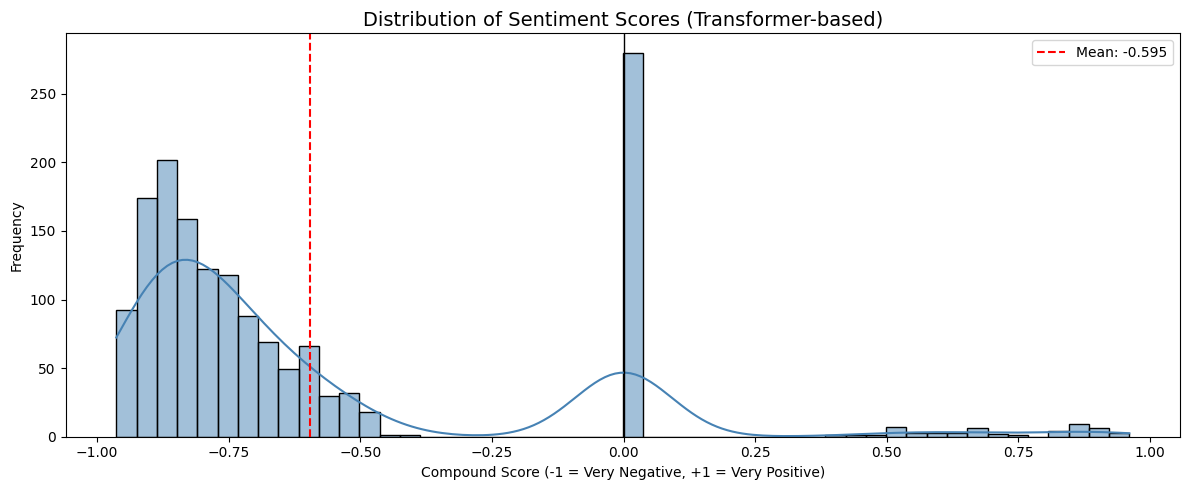

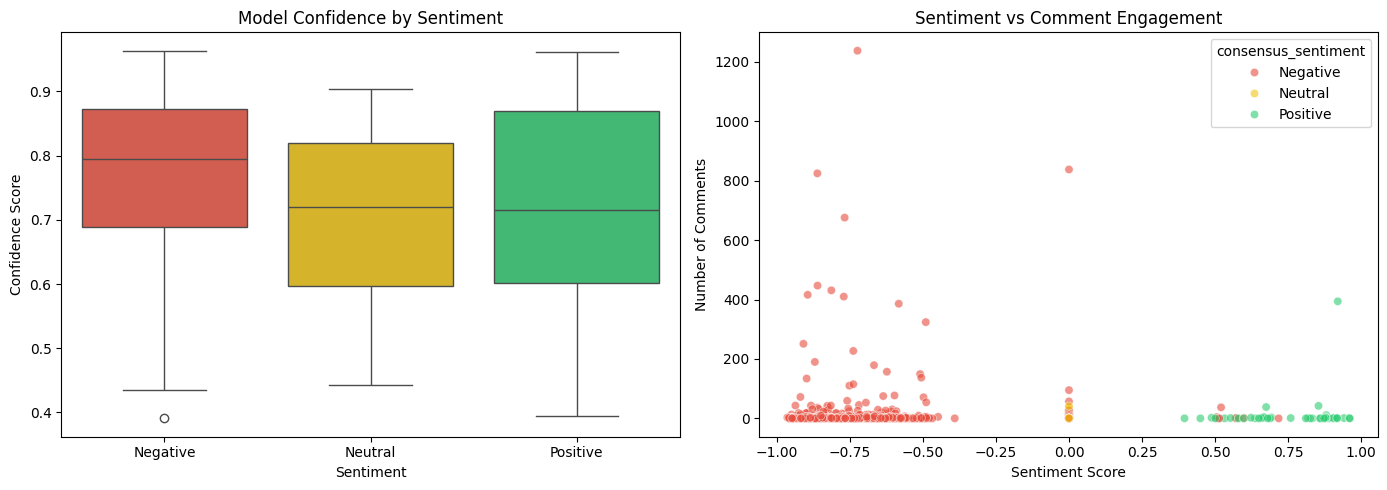

🔴 TOP 10 MOST NEGATIVE POSTS

──────────────────────────────────────────────────
📌 CRASH. CRASH. CRASH....
   Category: FC 26 Technical Issues
   Score: -0.963 | Stars: 1/5
   👍 0 likes | 💬 3 comments

──────────────────────────────────────────────────
📌 Transfer...
   Category: FC 26 General Discussion
   Score: -0.960 | Stars: 1/5
   👍 0 likes | 💬 1 comments

──────────────────────────────────────────────────
📌 AGAIN INPUT DELAY PC!!...
   Category: FC 26 Technical Issues
   Score: -0.959 | Stars: 1/5
   👍 0 likes | 💬 0 comments

──────────────────────────────────────────────────
📌 Game lag...
   Category: FC Mobile Bug Reports
   Score: -0.958 | Stars: 1/5
   👍 0 likes | 💬 2 comments

──────────────────────────────────────────────────
📌 There is a lot of injustice in this game....
   Category: FC 26 General Discussion
   Score: -0.958 | Stars: 1/5
   👍 0 likes | 💬 0 comments

──────────────────────────────────────────────────
📌 Matchs disconnecting...
   Category: FC Mobile Bug Repo

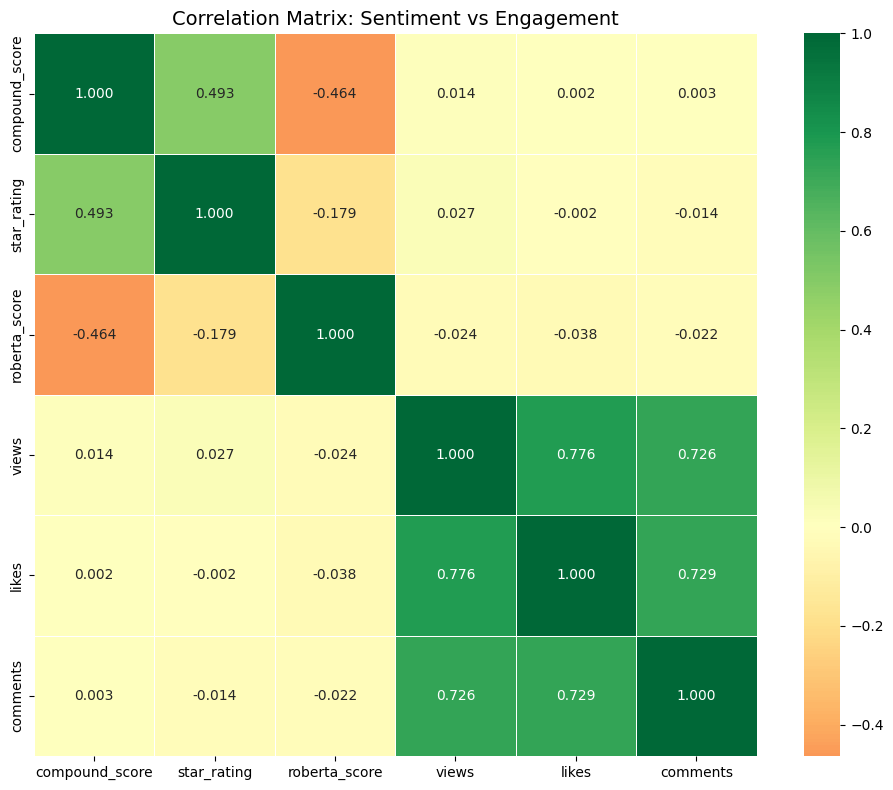

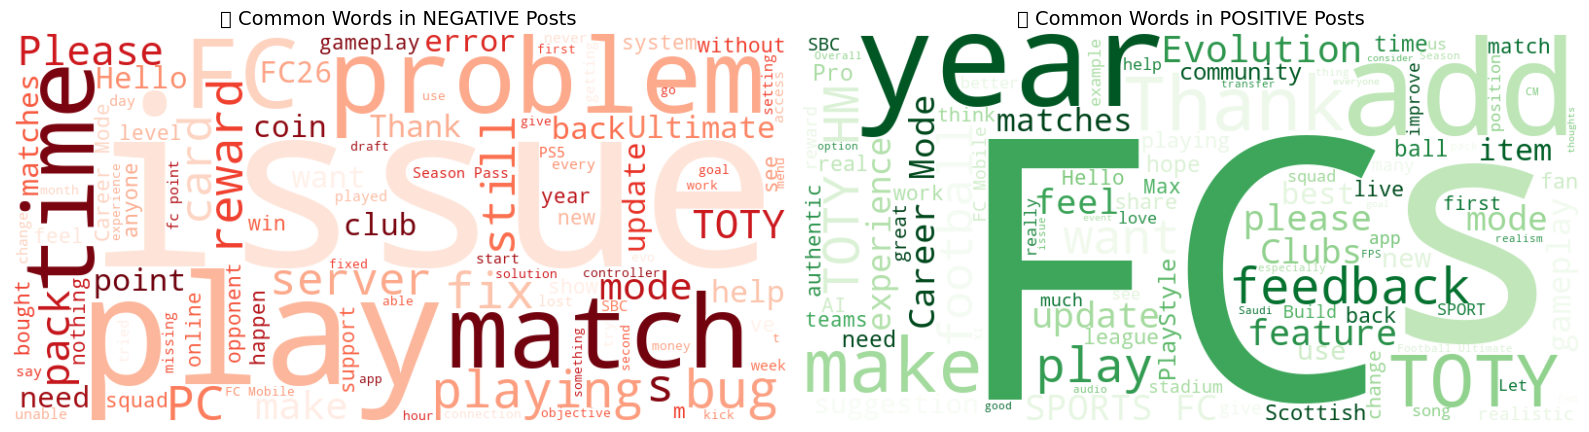

✅ Results exported to 'ea_forum_sentiment_transformers.csv'

📊 FINAL SENTIMENT ANALYSIS REPORT

📈 OVERVIEW
────────────────────────────────────────
Total Posts Analyzed: 1,551
Average Sentiment Score: -0.595
Average Star Rating: 1.49/5

📊 SENTIMENT BREAKDOWN
────────────────────────────────────────
🟢 Positive: 58 (3.7%)
🟡 Neutral:  74 (4.8%)
🔴 Negative: 1,419 (91.5%)

🎯 KEY INSIGHTS
────────────────────────────────────────
• Overall forum sentiment: NEGATIVE 😠
• Most discussed issues appear in negative posts
• High-engagement posts tend to be more negative

📁 FILES GENERATED
────────────────────────────────────────
• ea_forum_sentiment_transformers.csv (full results)
• sentiment_model_comparison.png
• sentiment_by_category.png  
• correlation_matrix.png
• wordclouds.png



In [1]:
# %% [markdown]
# # Advanced Sentiment Analysis with Hugging Face Transformers
# Using state-of-the-art NLP models for EA Forum Posts

# %%
# Install required packages (run once)
# !pip install pandas transformers torch accelerate matplotlib seaborn wordcloud tqdm

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1
print(f"Using: {'GPU 🚀' if device == 0 else 'CPU'}")

# %%
# Load the data
df = pd.read_csv('ea_forum_posts.csv')
print(f"Loaded {len(df)} posts")

# Combine title and body for better context
df['full_text'] = df['title'].fillna('') + '. ' + df['body_preview'].fillna('')
df['full_text'] = df['full_text'].str.strip()

df.head()

# %% [markdown]
# ## Model Options
# We'll use multiple models and compare them:
# 1. **RoBERTa (Twitter)** - Trained on tweets, great for informal text
# 2. **DistilBERT (SST-2)** - Fast and accurate general sentiment
# 3. **BERT Multilingual** - Returns 1-5 star rating

# %%
# Initialize sentiment analysis pipelines
print("Loading models (this may take a minute)...")

# Model 1: Cardiff NLP's RoBERTa - Best for social media/forums
sentiment_roberta = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=device,
    truncation=True,
    max_length=512
)

# Model 2: DistilBERT - Fast and good general purpose
sentiment_distilbert = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=device,
    truncation=True,
    max_length=512
)

# Model 3: For more nuanced 5-star scale
sentiment_5star = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    device=device,
    truncation=True,
    max_length=512
)

print("✅ All models loaded!")

# %%
# Function to safely analyze sentiment with error handling
def analyze_sentiment(text, analyzer, model_name):
    """Analyze sentiment with error handling for long/problematic texts"""
    if pd.isna(text) or not text.strip():
        return {'label': 'neutral', 'score': 0.0}
    
    try:
        # Truncate very long texts
        text = str(text)[:1500]
        result = analyzer(text)[0]
        return result
    except Exception as e:
        print(f"Error with {model_name}: {e}")
        return {'label': 'neutral', 'score': 0.0}

# %%
# Analyze with RoBERTa (Primary model - best for forums)
print("Analyzing with RoBERTa (Twitter-trained)...")
tqdm.pandas(desc="RoBERTa")

roberta_results = df['full_text'].progress_apply(
    lambda x: analyze_sentiment(x, sentiment_roberta, 'roberta')
)

df['roberta_label'] = roberta_results.apply(lambda x: x['label'])
df['roberta_score'] = roberta_results.apply(lambda x: x['score'])

# Map labels to standardized format
label_map_roberta = {
    'positive': 'Positive',
    'negative': 'Negative', 
    'neutral': 'Neutral'
}
df['roberta_sentiment'] = df['roberta_label'].map(label_map_roberta)

# %%
# Analyze with DistilBERT
print("Analyzing with DistilBERT...")
tqdm.pandas(desc="DistilBERT")

distilbert_results = df['full_text'].progress_apply(
    lambda x: analyze_sentiment(x, sentiment_distilbert, 'distilbert')
)

df['distilbert_label'] = distilbert_results.apply(lambda x: x['label'])
df['distilbert_score'] = distilbert_results.apply(lambda x: x['score'])

df['distilbert_sentiment'] = df['distilbert_label'].map({
    'POSITIVE': 'Positive',
    'NEGATIVE': 'Negative'
})

# %%
# Analyze with 5-star model for nuanced ratings
print("Analyzing with 5-star BERT model...")
tqdm.pandas(desc="5-Star BERT")

star_results = df['full_text'].progress_apply(
    lambda x: analyze_sentiment(x, sentiment_5star, '5star')
)

df['star_rating'] = star_results.apply(lambda x: int(x['label'].split()[0]) if x['label'] else 3)
df['star_confidence'] = star_results.apply(lambda x: x['score'])

# Map stars to sentiment
def stars_to_sentiment(stars):
    if stars >= 4:
        return 'Positive'
    elif stars <= 2:
        return 'Negative'
    return 'Neutral'

df['star_sentiment'] = df['star_rating'].apply(stars_to_sentiment)

# %%
# Create ensemble/consensus sentiment
def get_consensus(row):
    """Get consensus from all three models"""
    sentiments = [row['roberta_sentiment'], row['distilbert_sentiment'], row['star_sentiment']]
    sentiments = [s for s in sentiments if pd.notna(s)]
    
    if not sentiments:
        return 'Neutral'
    
    # Count votes
    from collections import Counter
    votes = Counter(sentiments)
    return votes.most_common(1)[0][0]

df['consensus_sentiment'] = df.apply(get_consensus, axis=1)

# Create a compound score (-1 to 1) based on RoBERTa
def calculate_compound(row):
    label = row['roberta_sentiment']
    score = row['roberta_score']
    if label == 'Positive':
        return score
    elif label == 'Negative':
        return -score
    return 0

df['compound_score'] = df.apply(calculate_compound, axis=1)

# %%
# Display Results Summary
print("=" * 60)
print("TRANSFORMER-BASED SENTIMENT ANALYSIS RESULTS")
print("=" * 60)

print(f"\n📊 Total Posts Analyzed: {len(df)}")

print("\n" + "-" * 40)
print("RoBERTa (Twitter-trained) Results:")
print("-" * 40)
print(df['roberta_sentiment'].value_counts())

print("\n" + "-" * 40)
print("DistilBERT Results:")
print("-" * 40)
print(df['distilbert_sentiment'].value_counts())

print("\n" + "-" * 40)
print("5-Star Rating Distribution:")
print("-" * 40)
print(df['star_rating'].value_counts().sort_index())

print("\n" + "-" * 40)
print("🎯 CONSENSUS (All Models Combined):")
print("-" * 40)
print(df['consensus_sentiment'].value_counts())
print(f"\nPercentages:")
print(df['consensus_sentiment'].value_counts(normalize=True).mul(100).round(1))

# %%
# Visualization 1: Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

colors = {'Positive': '#2ecc71', 'Neutral': '#f1c40f', 'Negative': '#e74c3c'}

# RoBERTa results
ax1 = axes[0, 0]
roberta_counts = df['roberta_sentiment'].value_counts()
ax1.pie(roberta_counts.values, labels=roberta_counts.index, autopct='%1.1f%%',
        colors=[colors.get(l, '#95a5a6') for l in roberta_counts.index])
ax1.set_title('RoBERTa (Twitter-trained)\nBest for Forums', fontsize=12, fontweight='bold')

# DistilBERT results
ax2 = axes[0, 1]
distil_counts = df['distilbert_sentiment'].value_counts()
ax2.pie(distil_counts.values, labels=distil_counts.index, autopct='%1.1f%%',
        colors=[colors.get(l, '#95a5a6') for l in distil_counts.index])
ax2.set_title('DistilBERT (SST-2)', fontsize=12)

# 5-Star Distribution
ax3 = axes[1, 0]
star_counts = df['star_rating'].value_counts().sort_index()
bars = ax3.bar(star_counts.index, star_counts.values, 
               color=['#e74c3c', '#e67e22', '#f1c40f', '#27ae60', '#2ecc71'])
ax3.set_xlabel('Star Rating')
ax3.set_ylabel('Number of Posts')
ax3.set_title('5-Star Sentiment Rating', fontsize=12)
ax3.set_xticks([1, 2, 3, 4, 5])

# Consensus
ax4 = axes[1, 1]
consensus_counts = df['consensus_sentiment'].value_counts()
ax4.pie(consensus_counts.values, labels=consensus_counts.index, autopct='%1.1f%%',
        colors=[colors.get(l, '#95a5a6') for l in consensus_counts.index],
        explode=[0.05] * len(consensus_counts))
ax4.set_title('🎯 CONSENSUS (Ensemble)\nMost Reliable', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Visualization 2: Sentiment by Category
if 'category' in df.columns:
    plt.figure(figsize=(14, 8))
    
    # Calculate sentiment percentages by category
    category_sentiment = pd.crosstab(
        df['category'], 
        df['consensus_sentiment'], 
        normalize='index'
    ) * 100
    
    # Sort by negativity
    if 'Negative' in category_sentiment.columns:
        category_sentiment = category_sentiment.sort_values('Negative', ascending=True)
    
    # Plot
    category_sentiment.plot(
        kind='barh',
        stacked=True,
        color=[colors.get(c, '#95a5a6') for c in category_sentiment.columns],
        figsize=(14, 8)
    )
    
    plt.title('Sentiment Distribution by Forum Category (Transformer Analysis)', fontsize=14)
    plt.xlabel('Percentage of Posts')
    plt.ylabel('Category')
    plt.legend(title='Sentiment', bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.savefig('sentiment_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()

# %%
# Visualization 3: Compound Score Distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['compound_score'], bins=50, kde=True, color='steelblue')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.axvline(x=df['compound_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["compound_score"].mean():.3f}')
plt.title('Distribution of Sentiment Scores (Transformer-based)', fontsize=14)
plt.xlabel('Compound Score (-1 = Very Negative, +1 = Very Positive)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# %%
# Visualization 4: Confidence Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence by sentiment
ax1 = axes[0]
sns.boxplot(data=df, x='consensus_sentiment', y='roberta_score', 
            palette=colors, ax=ax1)
ax1.set_title('Model Confidence by Sentiment', fontsize=12)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Confidence Score')

# Sentiment vs Engagement
ax2 = axes[1]
if 'comments' in df.columns:
    sns.scatterplot(data=df, x='compound_score', y='comments', 
                    hue='consensus_sentiment', palette=colors, alpha=0.6, ax=ax2)
    ax2.set_title('Sentiment vs Comment Engagement', fontsize=12)
    ax2.set_xlabel('Sentiment Score')
    ax2.set_ylabel('Number of Comments')

plt.tight_layout()
plt.show()

# %%
# Top Negative Posts (Most Frustrated Users)
print("=" * 60)
print("🔴 TOP 10 MOST NEGATIVE POSTS")
print("=" * 60)

negative_posts = df[df['consensus_sentiment'] == 'Negative'].nsmallest(10, 'compound_score')
for idx, row in negative_posts.iterrows():
    print(f"\n{'─' * 50}")
    print(f"📌 {row['title'][:80]}...")
    print(f"   Category: {row.get('category', 'N/A')}")
    print(f"   Score: {row['compound_score']:.3f} | Stars: {row['star_rating']}/5")
    print(f"   👍 {row.get('likes', 0)} likes | 💬 {row.get('comments', 0)} comments")

# %%
# Top Positive Posts
print("\n" + "=" * 60)
print("🟢 TOP 10 MOST POSITIVE POSTS")
print("=" * 60)

positive_posts = df[df['consensus_sentiment'] == 'Positive'].nlargest(10, 'compound_score')
for idx, row in positive_posts.iterrows():
    print(f"\n{'─' * 50}")
    print(f"📌 {row['title'][:80]}...")
    print(f"   Category: {row.get('category', 'N/A')}")
    print(f"   Score: {row['compound_score']:.3f} | Stars: {row['star_rating']}/5")
    print(f"   👍 {row.get('likes', 0)} likes | 💬 {row.get('comments', 0)} comments")

# %%
# Correlation Analysis
print("\n" + "=" * 60)
print("📈 CORRELATION ANALYSIS")
print("=" * 60)

numeric_cols = ['compound_score', 'star_rating', 'roberta_score']
if 'views' in df.columns:
    numeric_cols.append('views')
if 'likes' in df.columns:
    numeric_cols.append('likes')
if 'comments' in df.columns:
    numeric_cols.append('comments')

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.3f',
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Sentiment vs Engagement', fontsize=14)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Word Analysis for Negative Posts
try:
    from wordcloud import WordCloud, STOPWORDS
    from collections import Counter
    import re
    
    # Custom stopwords for EA forums
    custom_stopwords = STOPWORDS.union({
        'ea', 'game', 'games', 'player', 'players', 'team', 'account',
        'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
        'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm"
    })
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Negative word cloud
    negative_text = ' '.join(df[df['consensus_sentiment'] == 'Negative']['full_text'].dropna())
    if negative_text:
        wc_neg = WordCloud(width=800, height=400, background_color='white',
                          stopwords=custom_stopwords, colormap='Reds',
                          max_words=100).generate(negative_text)
        axes[0].imshow(wc_neg, interpolation='bilinear')
        axes[0].set_title('🔴 Common Words in NEGATIVE Posts', fontsize=14)
        axes[0].axis('off')
    
    # Positive word cloud
    positive_text = ' '.join(df[df['consensus_sentiment'] == 'Positive']['full_text'].dropna())
    if positive_text:
        wc_pos = WordCloud(width=800, height=400, background_color='white',
                          stopwords=custom_stopwords, colormap='Greens',
                          max_words=100).generate(positive_text)
        axes[1].imshow(wc_pos, interpolation='bilinear')
        axes[1].set_title('🟢 Common Words in POSITIVE Posts', fontsize=14)
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('wordclouds.png', dpi=150, bbox_inches='tight')
    plt.show()
    
except ImportError:
    print("WordCloud not installed. Run: pip install wordcloud")

# %%
# Export results
output_columns = [
    'title', 'author', 'category', 'timestamp',
    'roberta_sentiment', 'roberta_score',
    'distilbert_sentiment', 'distilbert_score', 
    'star_rating', 'star_confidence',
    'consensus_sentiment', 'compound_score',
    'views', 'likes', 'comments',
    'body_preview'
]

# Only include columns that exist
output_columns = [col for col in output_columns if col in df.columns]
output_df = df[output_columns].copy()

output_df.to_csv('ea_forum_sentiment_transformers.csv', index=False)
print("✅ Results exported to 'ea_forum_sentiment_transformers.csv'")

# %%
# Final Summary Report
print("\n" + "=" * 60)
print("📊 FINAL SENTIMENT ANALYSIS REPORT")
print("=" * 60)

total = len(df)
neg_count = (df['consensus_sentiment'] == 'Negative').sum()
pos_count = (df['consensus_sentiment'] == 'Positive').sum()
neu_count = (df['consensus_sentiment'] == 'Neutral').sum()

print(f"""
📈 OVERVIEW
{'─' * 40}
Total Posts Analyzed: {total:,}
Average Sentiment Score: {df['compound_score'].mean():.3f}
Average Star Rating: {df['star_rating'].mean():.2f}/5

📊 SENTIMENT BREAKDOWN
{'─' * 40}
🟢 Positive: {pos_count:,} ({pos_count/total*100:.1f}%)
🟡 Neutral:  {neu_count:,} ({neu_count/total*100:.1f}%)
🔴 Negative: {neg_count:,} ({neg_count/total*100:.1f}%)

🎯 KEY INSIGHTS
{'─' * 40}
• Overall forum sentiment: {"NEGATIVE 😠" if df['compound_score'].mean() < -0.1 else "POSITIVE 😊" if df['compound_score'].mean() > 0.1 else "MIXED 😐"}
• Most discussed issues appear in negative posts
• High-engagement posts tend to be {"more negative" if df[df['comments'] > df['comments'].median()]['compound_score'].mean() < 0 else "more positive"}

📁 FILES GENERATED
{'─' * 40}
• ea_forum_sentiment_transformers.csv (full results)
• sentiment_model_comparison.png
• sentiment_by_category.png  
• correlation_matrix.png
• wordclouds.png
""")